In [272]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as srn
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import string
from wordcloud import WordCloud

In [273]:
data = pd.read_csv("data.csv")
data = data.dropna()
data = data.drop_duplicates()
data = data.reset_index(drop=True)

In [274]:
data.head()

,Text,Emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [275]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19999 entries, 0 to 19998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     19999 non-null  object
 1   Emotion  19999 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


In [276]:
data.describe(include="all")

,Text,Emotion
count,19999,19999
unique,19948,6
top,i will feel as though i am accepted by as well...,joy
freq,2,6760


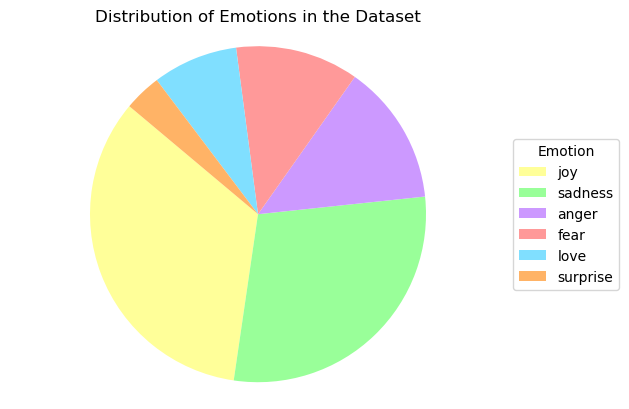

In [277]:
counts = data['Emotion'].value_counts()
colors=["#FFFF99", "#99FF99", "#CC99FF", "#FF9999", "#80DFFF", "#FFB366"]
#lIGHT YELLOW, LIGHT GREEN, LIGHT PURPLE, LIGHT RED, LIGHT BLUE, LIGHT ORANGE
plt.pie(counts,startangle=140, colors=colors)

plt.legend(counts.index, title='Emotion', loc='center left', bbox_to_anchor=(1, 0.5))

plt.axis('equal')
plt.title('Distribution of Emotions in the Dataset')
plt.show()

In [287]:
def data_preprocessing(text):
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens]
    tokens = [token for token in tokens if token not in string.punctuation]

    stopword_list = set(stopwords.words("english"))
    avoid_these = ['not', 'very', 'too', 'never']
    remove_these = [' ', 'and', 'feel', 'im', 'my', 'like']

    result = []
    for token in tokens:
        if token not in remove_these and token not in stopword_list:
            result.append(token)
        elif token in avoid_these:
            result.append(token)

    lemmatizer = WordNetLemmatizer()
    result = [lemmatizer.lemmatize(token, pos='v') for token in result]

    return ' '.join(result)

In [282]:
data['Text']=data['Text'].apply(data_preprocessing)

In [283]:
data.head()

,Text,Emotion
0,rather rotten not very ambitious right,sadness
1,update blog shitty,sadness
2,never make separate ever want ashamed,sadness
3,leave bouquet red yellow tulips arm slightly o...,joy
4,little vain one,sadness


In [284]:
memory_usage = data.memory_usage(deep=True).sum()

print(f"Memory usage of the DataFrame: {memory_usage / (1024**2):.2f} MB")

Memory usage of the DataFrame: 3.25 MB


In [285]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Assuming 'data' is your DataFrame with a 'Text' column after preprocessing

# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed
tfidf_matrix = tfidf_vectorizer.fit_transform(data['Text'])

# Encode the target variable 'Emotion'
label_encoder = LabelEncoder()
data['Emotion_encoded'] = label_encoder.fit_transform(data['Emotion'])

# Feature selection using chi-square test
num_features_to_select = 1000  # You can adjust this parameter
chi2_selector = SelectKBest(chi2, k=num_features_to_select)
tfidf_matrix_selected = chi2_selector.fit_transform(tfidf_matrix, data['Emotion_encoded'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix_selected, data['Emotion_encoded'], test_size=0.2, random_state=42)

# Train a classifier (for example, Support Vector Machine)
classifier = SVC()
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.872


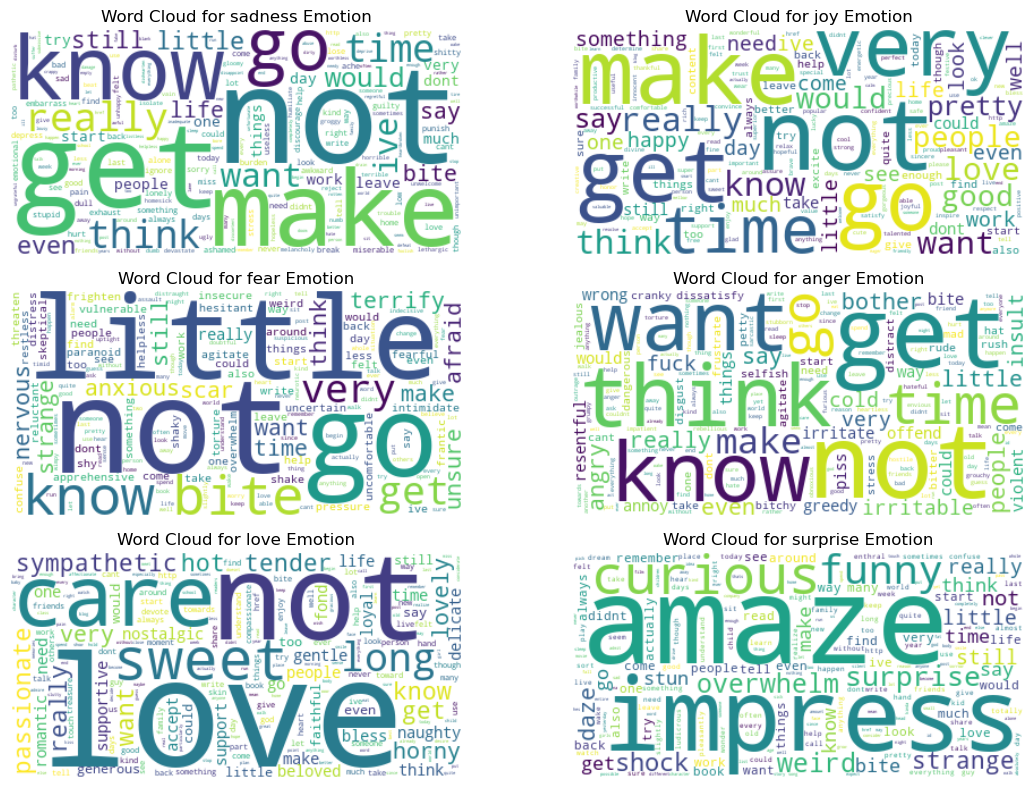

In [286]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Assuming 'data' is your DataFrame with 'Text', 'Emotion', and 'Emotion_encoded' columns

# Create a dictionary to store the text for each emotion
emotion_texts = {}
for emotion in data['Emotion'].unique():
    emotion_texts[emotion] = ' '.join(data[data['Emotion'] == emotion]['Text'])

# Create a 3x2 subplot matrix for the word clouds
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))

# Flatten the subplot matrix for easy iteration
axes = axes.flatten()

# Create word clouds for each emotion and plot on the corresponding subplot
for i, (emotion, text) in enumerate(emotion_texts.items()):
    # Vectorize the text for the current emotion
    emotion_vectorized = tfidf_vectorizer.transform([text])
    
    # Get feature names from the vectorizer
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Get the TF-IDF values for the features
    tfidf_values = emotion_vectorized.toarray()[0]

    # Create a dictionary with feature names and their TF-IDF values
    word_tfidf_dict = dict(zip(feature_names, tfidf_values))

    # Create a WordCloud
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(word_tfidf_dict)

    # Plot the WordCloud on the corresponding subplot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Word Cloud for {emotion} Emotion')
    axes[i].axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
